# 一个简单的 PyDESeq2 工作流程
链接地址：https://pydeseq2.readthedocs.io/en/latest/_downloads/aa8b9206c152b88de97da689ce07a2ea/plot_minimal_pydeseq2_pipeline.ipynb

在此示例中，我们展示如何使用 PyDESeq2 对 bulk RNA-seq 数据执行简单的差异表达分析。


我们首先导入所需的包，并设置一个可选的保存结果的路径。


In [2]:
import os
import pickle as pkl            # 标准库不需要安装

from pydeseq2.dds import DeseqDataSet            #  pip install pydeseq2
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

SAVE = False  # 是否保存该笔记本的输出

if SAVE:
    # 将此路径替换为你希望保存结果的目录路径
    OUTPUT_PATH = "../output_files/synthetic_example"
    os.makedirs(OUTPUT_PATH, exist_ok=True)  # 如果路径不存在则创建





## 数据加载

要执行差异表达分析（DEA），PyDESeq2 需要两类输入：

  * 一个形状为“样本数 × 基因数”的计数矩阵，包含读取计数（非负整数），
  * 元数据（或“列”数据），形状为“样本数 × 变量数”，包含将用于将数据划分为队列的样本注释。

两者都应以 pandas DataFrame 的形式提供（[pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)）。



为了说明所需的数据格式，我们加载了一个合成示例数据集，该数据可通过 PyDESeq2 的 API 使用 :func:`utils.load_example_data` 获取。
你也可以用自己的数据集替换它。


In [3]:
counts_df = load_example_data(
    modality="raw_counts",
    dataset="synthetic",
    debug=False,
)

metadata = load_example_data(
    modality="metadata",
    dataset="synthetic",
    debug=False,
)

print(counts_df)

           gene1  gene2  gene3  gene4  gene5  gene6  gene7  gene8  gene9  \
sample1       12     21      4    130     18      0     16     54     49   
sample2        1     44      2     63     11     10     70     32     57   
sample3        4      4     11    180     21      3     28     34     65   
sample4        1     10      2    100     44      9     28     16     33   
sample5        1     11      6    135     16      2     32     29     31   
...          ...    ...    ...    ...    ...    ...    ...    ...    ...   
sample96       7     26      3     67     11      4     41     44     54   
sample97       1     14      3     71     33      5     19     42     25   
sample98      10     36      2     72     11      2     66     27     16   
sample99      18     14      3     66     53     11     32     19     79   
sample100     21      9      3     42     13     13     19     78     30   

           gene10  
sample1         3  
sample2         9  
sample3         2  
sample4

In [9]:
print(metadata)

          condition group
sample1           A     X
sample2           A     Y
sample3           A     X
sample4           A     Y
sample5           A     X
...             ...   ...
sample96          B     Y
sample97          B     X
sample98          B     Y
sample99          B     X
sample100         B     Y

[100 rows x 2 columns]


在此示例中，元数据包含两列：``condition`` 和 ``group``，代表两类二级注释。在第一部分中，我们仅使用 ``condition`` 因子。稍后我们将看到如何在分析中同时使用 `condition` 和 ``group`` 因子（参见 `multifactor_ref`）。


### 数据过滤

在继续进行差异表达分析之前，预处理数据是一个好习惯，例如删除注释缺失的样本以及剔除表达量非常低的基因。在我们的合成数据集中这一步不是必需的，但在使用真实数据时不要忘记执行此步骤。下面的代码可以用于该预处理。

我们首先删除 ``condition`` 为 ``NaN`` 的样本。如果你使用的是其他数据集，请不要忘记将 "condition" 更换为你希望在分析中作为设计因子的 `metadata` 列名。


In [10]:
samples_to_keep = ~metadata.condition.isna()
counts_df = counts_df.loc[samples_to_keep]
metadata = metadata.loc[samples_to_keep]

<div class="alert alert-info"><h4>注意</h4><p>如果设计因子包含 ``NaN`` 条目，初始化 :class:`DeseqDataSet <dds.DeseqDataSet>` 时，PyDESeq2 会抛出错误。</p></div>


接下来，我们过滤出总读取计数少于 10 的基因。再次注意，在这个合成数据集中没有满足该条件的基因。


In [11]:
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep]

现在我们已加载并过滤了数据，可以继续进行差异分析。


## 单因子分析

在此首次分析中，我们忽略 ``group`` 变量，使用 ``condition`` 列作为设计因子。也就是说，我们比较具有 ``condition B`` 的样本与具有 ``condition A`` 的样本的基因表达。




### 使用 :`DeseqDataSet` 类对计数进行建模

我们首先从计数和元数据创建一个 :class:`DeseqDataSet` 对象。
`DeseqDataSet` 会从数据中拟合离散度（dispersion）和对数折叠变化（LFC）参数，并将其存储。


In [13]:

inference = DefaultInference(n_cpus=8) 
# 使用8个CPU核心进行并行计算
# 加速DESeq2的统计计算过程包括：
# 离散度估计
# 模型拟合
# Log2 Fold Change计算
# p值计算

dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design="~condition",
    refit_cooks=True,   
    inference=inference,
    # n_cpus=8, # n_cpus can be specified here or in the inference object
)


`DeseqDataSet` 有两个必需的参数：``counts`` 和 ``metadata`` DataFrame，如本教程前面加载的那样。

接下来，我们应指定一个 ``design``，即描述设计的 Wilkinson 公式，或者直接提供设计矩阵。这里我们提供一个公式（字符串），`formulaic`（https://github.com/matthewwardrop/formulaic）能够解析该公式。

<div class="alert alert-info"><h4>注意</h4><p>``design`` 中的 ``"condition"`` 因子对应于我们之前加载的 ``metadata`` DataFrame 中的一列。你可能需要根据自己的数据集进行更改。</p></div>

还可以指定其他可选参数（见 :doc:`API 文档 </api/docstrings/pydeseq2.dds.DeseqDataSet>`）。
其中，``refit_cooks`` 参数（默认为 ``True``）控制是否对 Cooks 离群值进行重拟合（通常建议重拟合），``n_cpus`` 设置用于计算的 CPU 数量。这里我们使用 8 个线程。可根据你的环境调整，或设为 ``None`` 使用所有可用 CPU。

<div class="alert alert-info"><h4>注意</h4><p>对于提供的合成数据，不会有 Cooks 离群值。</p></div>

一旦初始化了 `DeseqDataSet`，我们可以运行 `deseq2()` 方法来拟合离散度和 LFC。


In [14]:
dds.deseq2()


if SAVE:
    with open(os.path.join(OUTPUT_PATH, "dds.pkl"), "wb") as f:
        pkl.dump(dds, f)

Fitting size factors...
... done in 0.00 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 0.01 seconds.

Fitting dispersion trend curve...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



In [15]:
print(dds)

AnnData object with n_obs × n_vars = 100 × 10
    obs: 'condition', 'group', 'size_factors', 'replaceable'
    var: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', '_mu_LFC', '_hat_diagonals'
    varm: 'LFC'
    layers: 'normed_counts', '_mu_hat', 'cooks'


因此，参数按照 :class:`AnnData <anndata.AnnData>` 的数据结构进行存储，使用基于键的数据字段。具体来说：

- ``X`` 存储计数数据，
- ``obs`` 存储一维样本级数据，例如设计因子和 ``"size_factors"``，
- ``obsm`` 存储多维样本级数据，例如 ``"design_matrix"``，
- ``var`` 存储一维基因级数据，例如基因名和 ``"dispersions"``，
- ``varm`` 存储多维基因级数据，例如 ``"LFC"``。

例如，下面是我们如何访问离散度和 LFC（以自然对数尺度）：


In [ ]:
# 离散度 = 描述基因表达数据的变异程度

# 是负二项分布模型的参数

# 离散度越大，表示该基因的表达变异越大

print(dds.obsm["design_matrix"])
print(dds.var["dispersions"])

           Intercept  condition[T.B]
sample1          1.0               0
sample2          1.0               0
sample3          1.0               0
sample4          1.0               0
sample5          1.0               0
...              ...             ...
sample96         1.0               1
sample97         1.0               1
sample98         1.0               1
sample99         1.0               1
sample100        1.0               1

[100 rows x 2 columns]


In [22]:
# 假设某个基因的LFC = 1.0
# 这意味着：2(1.0) = 2倍变化
# 即该基因在处理组中的表达量是对照组的约2.7倍

# LFC = 0 表示无变化（2(0) = 1）
# LFC > 0 表示上调
# LFC < 0 表示下调

print(dds.varm["LFC"])

        Intercept  condition[T.B]
gene1    1.891436        0.438632
gene2    2.851662        0.373296
gene3    1.787780       -0.438645
gene4    4.741958       -0.285647
gene5    3.077798        0.403457
gene6    1.678536        0.001010
gene7    3.291025        0.093116
gene8    3.785129       -0.187604
gene9    3.682882       -0.147443
gene10   2.300515        0.267562


In [21]:
import numpy as np

np.log2(2)


np.float64(1.0)



### 使用 :class:`DeseqStats` 进行统计分析

在拟合了离散度和 LFC 之后，我们可以进行统计检验以计算差异表达的 p 值和校正后的 p 值。这是 :class:`DeseqStats` 的作用。它有两个必需参数：

- ``dds``，应为已 *拟合* 的 :class:`DeseqDataSet <pydeseq2.dds.DeseqDataSet>` 对象，
- ``contrast``，它是一个由三字符串组成的列表，形式为
  ``["variable", "tested_level", "control_level"]``，或直接传入对比向量。


In [24]:
ds = DeseqStats(dds, contrast=["condition", "B", "A"], inference=inference)



它还有一组可选关键字参数（参见 :doc:`API 文档 </api/docstrings/pydeseq2.ds.DeseqStats>`），其中包含：

- ``alpha``：p 值和校正后 p 值的显著性阈值（默认 ``0.05``），
- ``cooks_filter``：是否根据 Cooks 离群值过滤 p 值（默认 ``True``），
- ``independent_filter``：是否执行独立过滤以纠正 p 值趋势（默认 ``True``）。

在 `多因子分析部分<multifactor_ref>` 中，我们还会看到如何使用 ``contrast`` 参数来指定应根据哪个变量来比较样本。


#### Wald 检验

PyDESeq2 使用 Wald 检验计算 p 值。可以使用 :meth:`summary() <DeseqStats.summary>` 方法执行此操作，该方法运行完整的统计分析，包括 Cooks 过滤和多重检验校正。


Running Wald tests...
... done in 2.93 seconds.



Log2 fold change & Wald test p-value: condition B vs A
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541317        0.632812  0.289101  2.188898  0.028604  0.064150
gene2    21.281239        0.538552  0.149963  3.591236  0.000329  0.001646
gene3     5.010123       -0.632830  0.295236 -2.143476  0.032075  0.064150
gene4   100.517961       -0.412102  0.118629 -3.473868  0.000513  0.001710
gene5    27.142450        0.582065  0.154706  3.762409  0.000168  0.001646
gene6     5.413043        0.001457  0.310311  0.004696  0.996253  0.996253
gene7    28.294023        0.134338  0.149945  0.895917  0.370297  0.411441
gene8    40.358344       -0.270656  0.136401 -1.984261  0.047227  0.078711
gene9    37.166183       -0.212715  0.133243 -1.596437  0.110391  0.143147
gene10   11.589325        0.386011  0.244588  1.578207  0.114518  0.143147


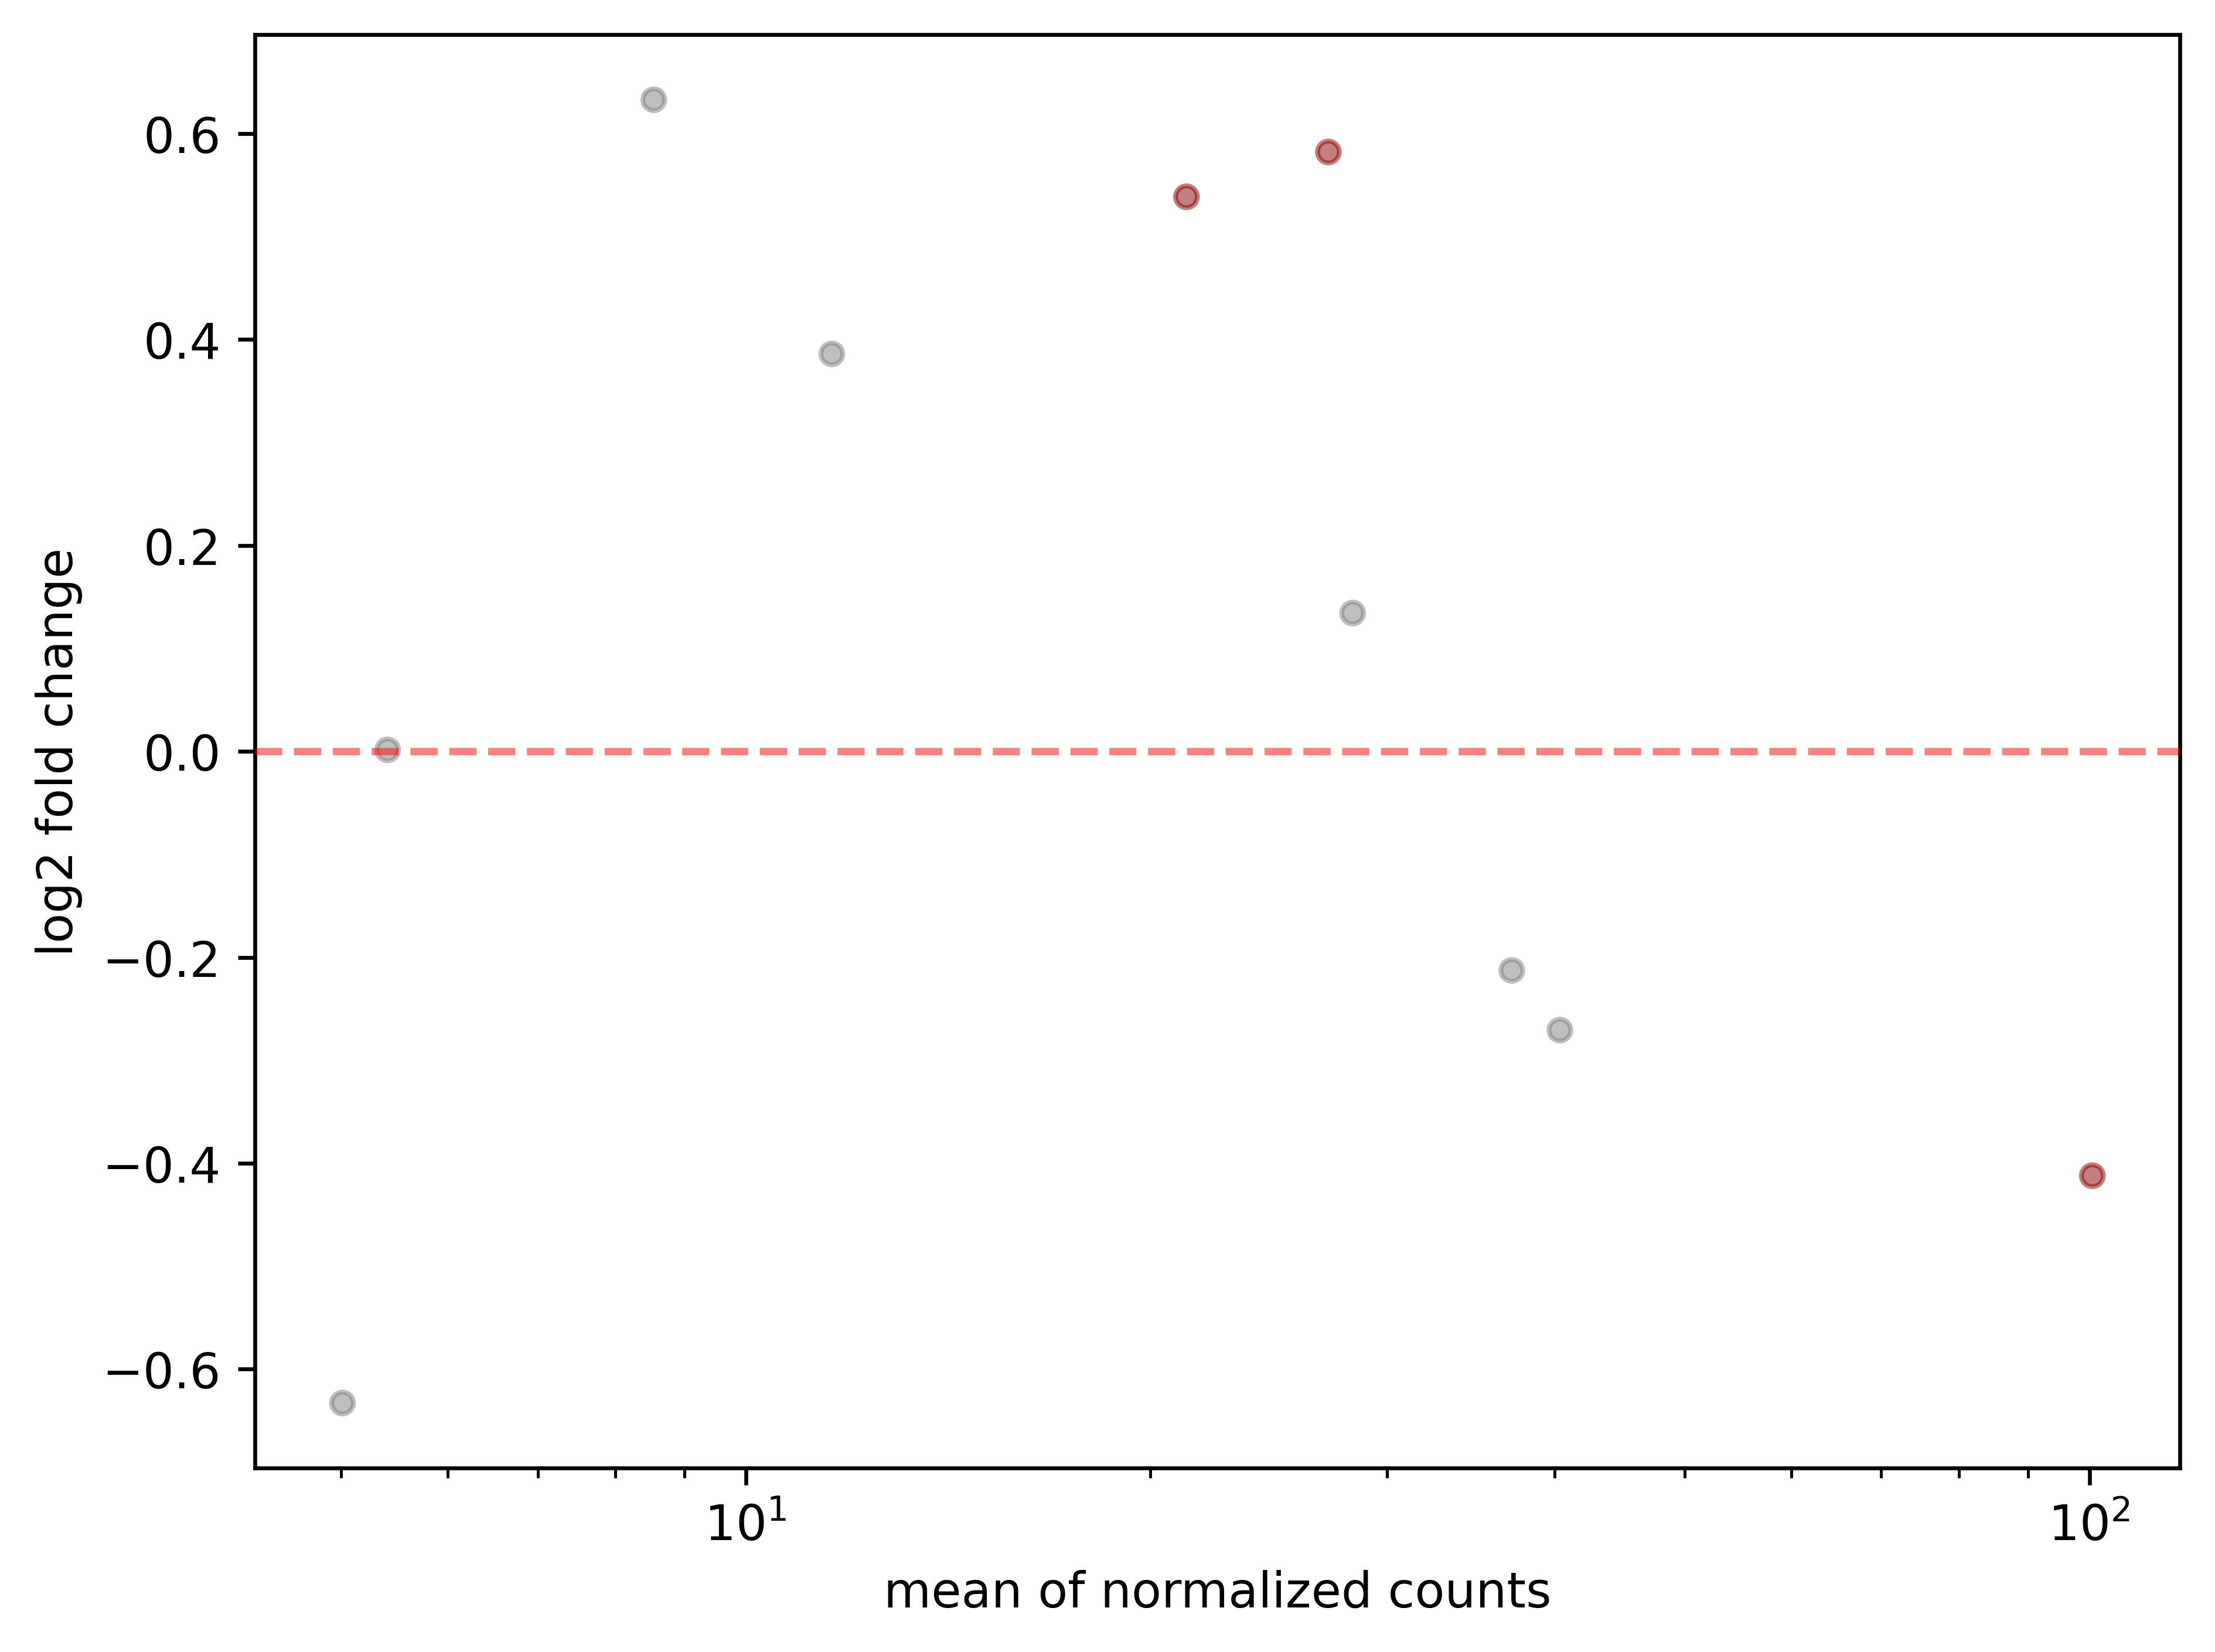

In [25]:
ds.summary()
ds.plot_MA(s=20)  
if SAVE:
    with open(os.path.join(OUTPUT_PATH, "ds.pkl"), "wb") as f:
        pkl.dump(ds, f)

结果随后存储在 ``results_df`` 属性（即 ``ds.results_df``）中。


#### 可选：基于阈值的检验

用户可以指定零假设下的（以 log2 为单位的）折叠变化阈值和一个备择假设，以重新计算 Wald 统计量和 p 值。
备择假设对应于用户想要发现的情况，而不是零假设。它可以取以下值之一：
``["greaterAbs", "lessAbs", "greater", "less"]``。



Running Wald tests...
... done in 2.74 seconds.



Log2 fold change & Wald test p-value: condition B vs A
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541317        0.632812  0.289101  1.842998  0.065329  0.142223
gene2    21.281239        0.538552  0.149963  2.924404  0.003451  0.017256
gene3     5.010123       -0.632830  0.295236 -1.804763  0.071112  0.142223
gene4   100.517961       -0.412102  0.118629 -2.630904  0.008516  0.028386
gene5    27.142450        0.582065  0.154706  3.116020  0.001833  0.017256
gene6     5.413043        0.001457  0.310311  0.000000  1.000000  1.000000
gene7    28.294023        0.134338  0.149945  0.229004  0.818866  0.909851
gene8    40.358344       -0.270656  0.136401 -1.251130  0.210887  0.346086
gene9    37.166183       -0.212715  0.133243 -0.845931  0.397591  0.496989
gene10   11.589325        0.386011  0.244588  1.169357  0.242260  0.346086


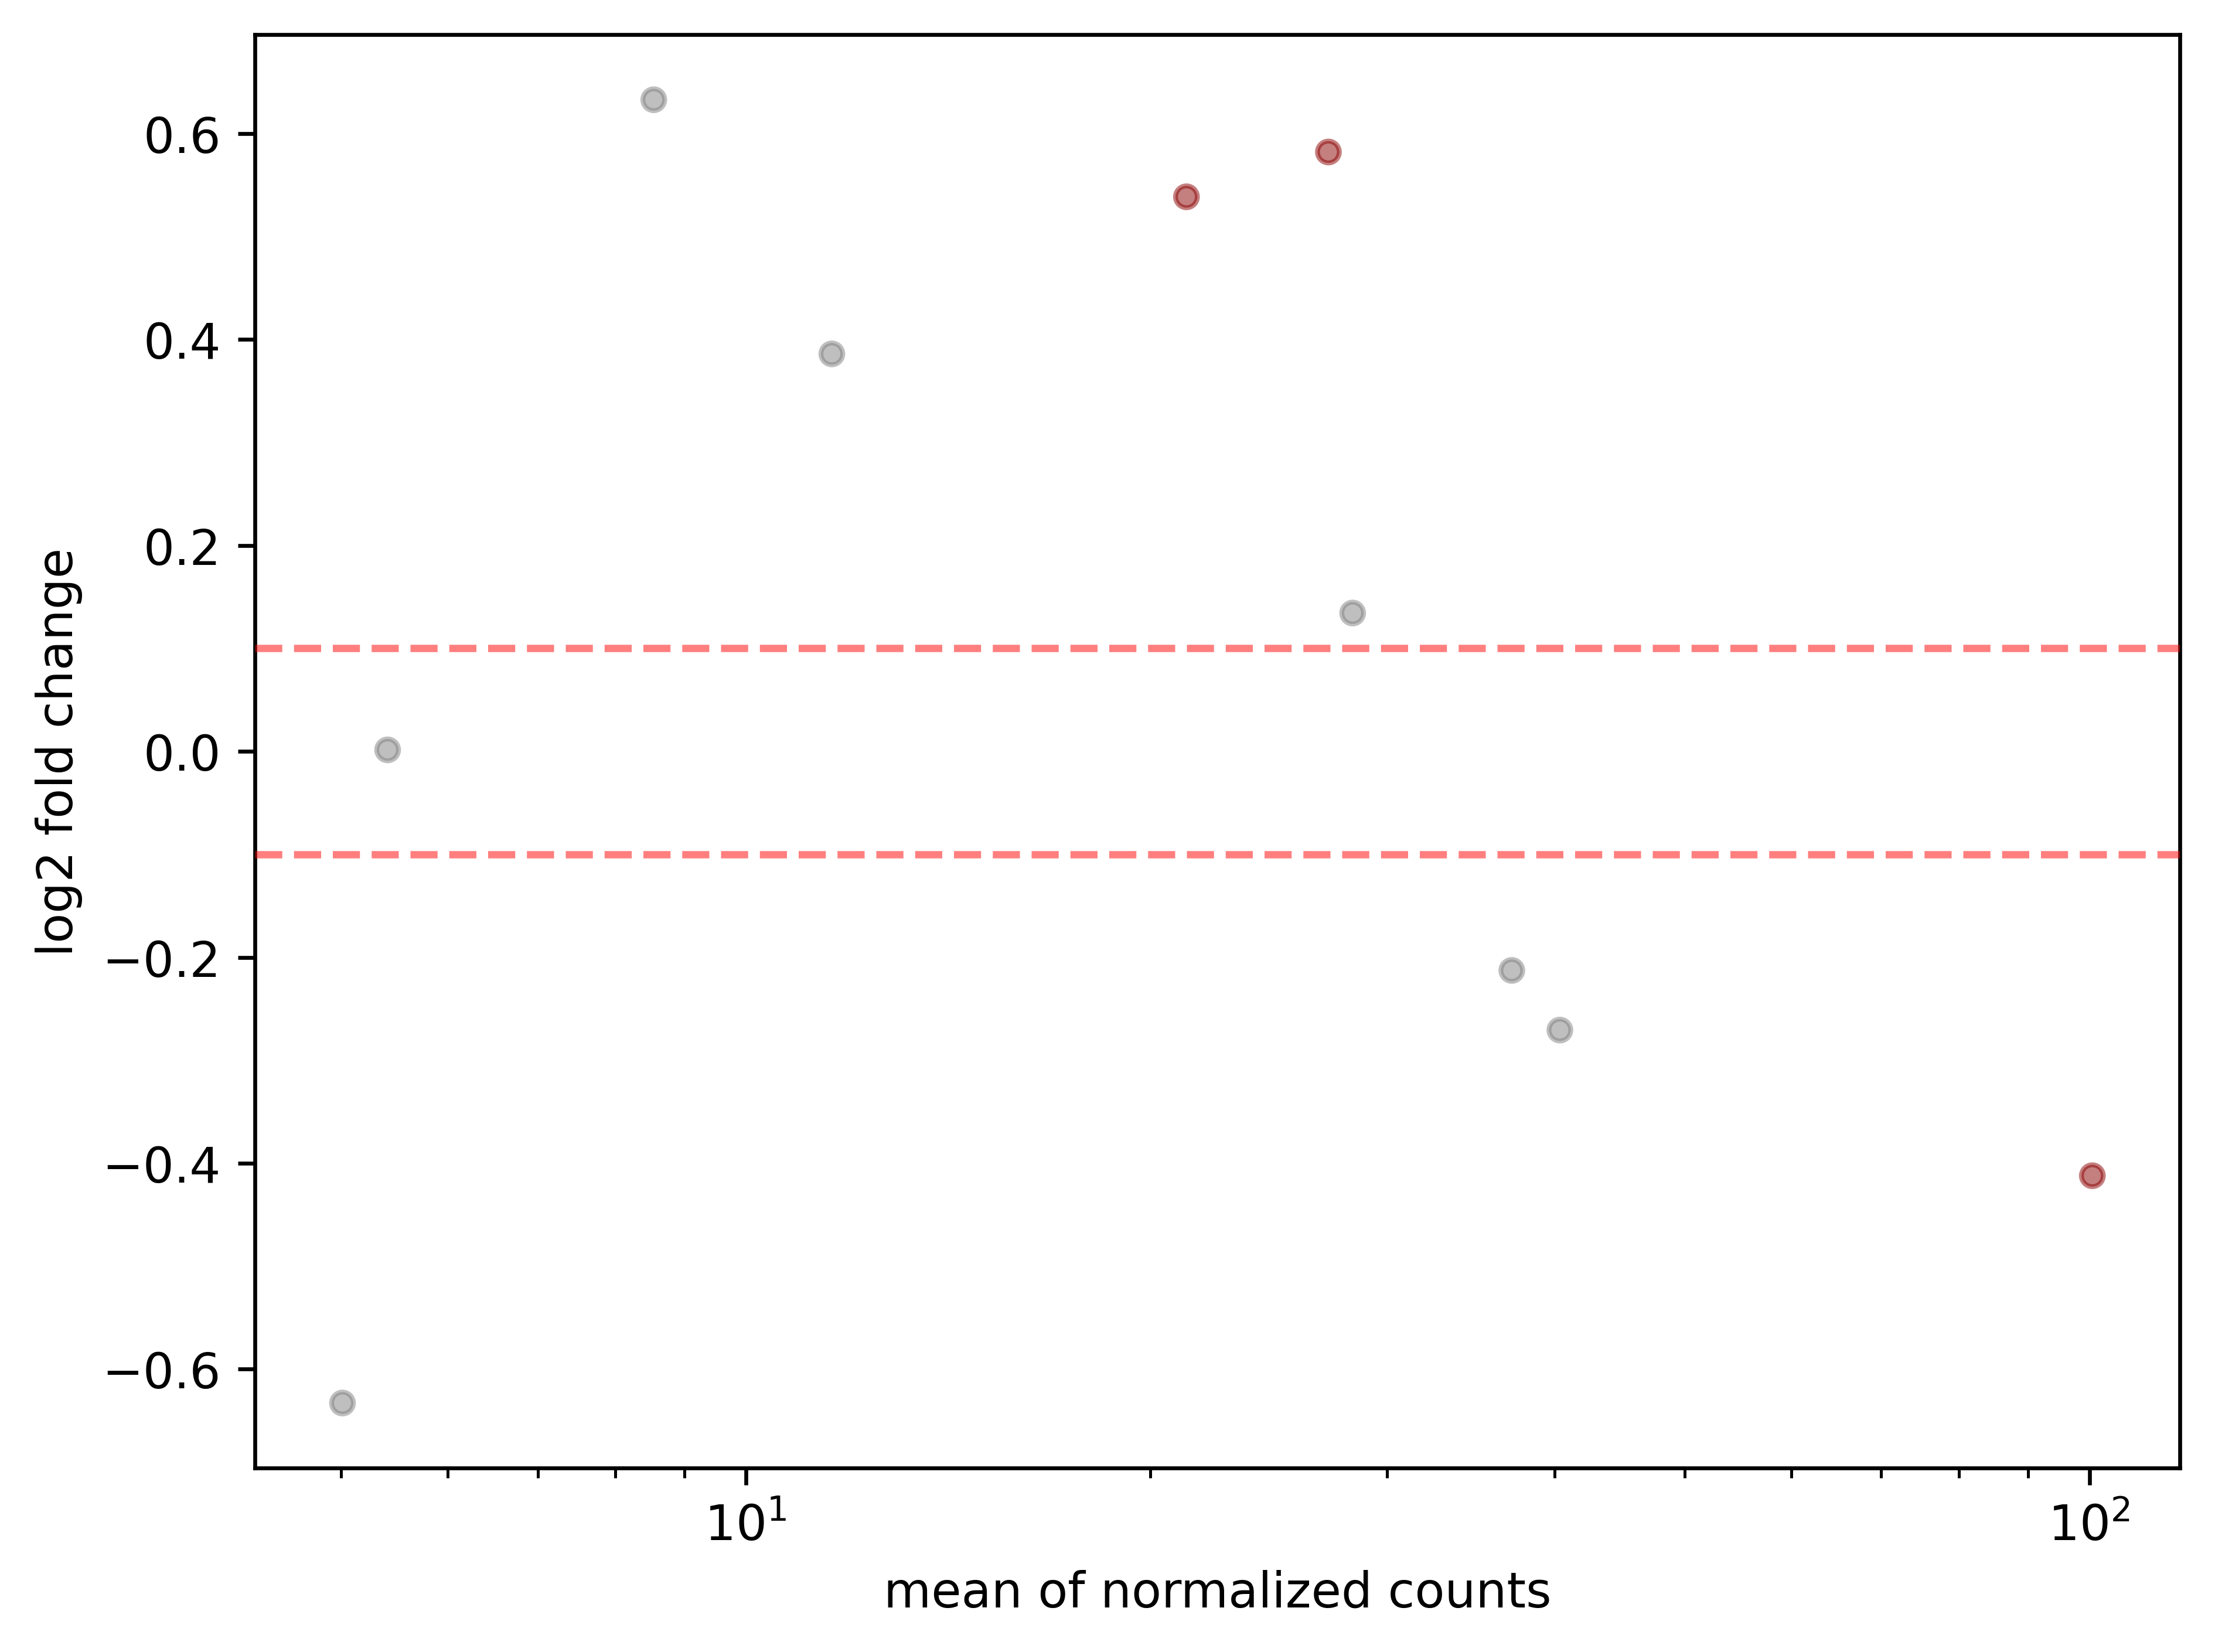

In [ ]:
# 四个备择假设选项的含义
# 1. "greaterAbs" - 双侧检验（绝对值大于阈值）

# 零假设 H₀: |log2FC| ≤ 阈值
# 备择假设 H₁: |log2FC| > 阈值
# 应用场景：寻找显著上调或下调的基因（最常用）

# 2. "lessAbs" - 双侧检验（绝对值小于阈值）

# 零假设 H₀: |log2FC| ≥ 阈值  
# 备择假设 H₁: |log2FC| < 阈值
# 应用场景：寻找变化不大的基因（较少使用）

# 3. "greater" - 单侧检验（大于阈值）

# 零假设 H₀: log2FC ≤ 阈值
# 备择假设 H₁: log2FC > 阈值
# 应用场景：专门寻找显著上调的基因

# 4. "less" - 单侧检验（小于阈值）
# 零假设 H₀: log2FC ≥ 阈值
# 备择假设 H₁: log2FC < 阈值
ds.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")
ds.plot_MA(s=20)  # s=20指的是点的大小

#### LFC 收缩
LFC收缩的作用
减少噪声影响

极端值被拉向中心，但相对顺序保持不变

对低表达基因的LFC估计进行"收缩"向零

对高表达基因的LFC保持相对不变

为了可视化或后处理，可能需要对 LFC 进行收缩。该功能由 :meth:`lfc_shrink() <DeseqStats.lfc_shrink>` 方法实现，该方法接受要收缩的系数名称（即设计矩阵 `dds.obsm["design_matrix"]` 的列名）作为参数。例如，要收缩 ``condition B`` 的 LFC，可运行：


In [27]:
#"对条件B相对于条件A的log fold change估计值进行统计收缩，以减少低表达基因的估计误差"
# 假设我们有4个基因的表达数据
# 基因表达量 = {
#     "gene1": 在条件A: 100, 在条件B: 200,   # 真实2倍变化
#     "gene2": 在条件A: 5,   在条件B: 15,    # 真实3倍变化，但计数低，噪声大
#     "gene3": 在条件A: 500, 在条件B: 1000,  # 真实2倍变化，计数高，可靠
#     "gene4": 在条件A: 8,   在条件B: 9,     # 几乎无变化，但噪声可能造成假象
# }
ds.lfc_shrink(coeff="condition[T.B]")

if SAVE:
    with open(os.path.join(OUTPUT_PATH, "shrunk_results.pkl"), "wb") as f:
        pkl.dump(ds, f)

Shrunk log2 fold change & Wald test p-value: condition[T.B]
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541317        0.408148  0.294271  1.842998  0.065329  0.142223
gene2    21.281239        0.480228  0.151198  2.924404  0.003451  0.017256
gene3     5.010123       -0.396066  0.300796 -1.804763  0.071112  0.142223
gene4   100.517961       -0.374346  0.118704 -2.630904  0.008516  0.028386
gene5    27.142450        0.521534  0.156204  3.116020  0.001833  0.017256
gene6     5.413043        0.000715  0.239203  0.000000  1.000000  1.000000
gene7    28.294023        0.103473  0.141497  0.229004  0.818866  0.909851
gene8    40.358344       -0.226414  0.133479 -1.251130  0.210887  0.346086
gene9    37.166183       -0.175964  0.129142 -0.845931  0.397591  0.496989
gene10   11.589325        0.239935  0.231986  1.169357  0.242260  0.346086


Fitting MAP LFCs...
... done in 0.01 seconds.



<div class="alert alert-info"><h4>注意</h4><p>运行 :meth:`lfc_shrink() <DeseqStats.lfc_shrink>` 将用收缩后的值覆盖 :class:`DeseqStats` 对象的对数折叠变化（及其标准误差）。可以使用 ``shrunk_LFCs`` 标志来检查这一点。</p></div>


In [28]:
print(ds.shrunk_LFCs)  # 仅当运行过 lfc_shrink() 时，此值才为 True。

True


## 多因子分析

.. currentmodule:: pydeseq2.dds

到目前为止，我们仅使用了 `metadata` 的 ``condition`` 列，它将样本分为条件 ``A`` 和 ``B``。然而，``metadata`` 还包含第二列，根据 ``group`` 将样本分为 ``X`` 和 ``Y``。


In [29]:
print(metadata)

          condition group
sample1           A     X
sample2           A     Y
sample3           A     X
sample4           A     Y
sample5           A     X
...             ...   ...
sample96          B     Y
sample97          B     X
sample98          B     Y
sample99          B     X
sample100         B     Y

[100 rows x 2 columns]


多因子分析的目标是使用 *两个* 变量来拟合 LFC。

### 计数建模

要使用 PyDESeq2 执行多因子分析，我们从初始化 :class:`DeseqDataSet` 开始，但在 ``design`` 参数中提供多个我们想要使用的变量。


In [30]:
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design="~group + condition",
    refit_cooks=True,
    inference=inference,
)

与单因子分析类似，我们使用 :meth:`deseq2() <DeseqDataSet.deseq2>` 方法来拟合离散度和 LFC。


In [31]:
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.01 seconds.

Fitting dispersion trend curve...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.



现在，如果我们打印对数折叠变化（LFC），除了截距外会有两列：一列对应 ``group`` 变量，另一列对应 ``condition``。


In [32]:
print(dds.varm["LFC"])

        Intercept  group[T.Y]  condition[T.B]
gene1    1.560313    0.525572        0.507013
gene2    2.812255    0.079229        0.371026
gene3    2.059577   -0.602606       -0.467002
gene4    4.919837   -0.385197       -0.293527
gene5    2.973802    0.194078        0.407582
gene6    1.846061   -0.352410       -0.013510
gene7    3.235967    0.106773        0.093654
gene8    3.640464    0.270819       -0.188248
gene9    3.645334    0.074474       -0.148346
gene10   2.136670    0.303009        0.270003


.. currentmodule:: pydeseq2.ds

### 统计分析

p 值的计算与之前类似，通过具有 :meth:`summary() <DeseqStats.summary>` 方法的 :class:`DeseqStats` 对象。``contrast`` 参数允许我们确定想要获取 LFC 和 p 值的变量。
它是一个由三字符串组成的列表，形式为
``["variable", "tested level", "reference level"]``。
例如，要比较 condition B 与 condition A，我们设置 ``contrast=["condition", "B", "A"]``。


In [33]:
ds_B_vs_A = DeseqStats(dds, contrast=["condition", "B", "A"], inference=inference)

让我们拟合 p 值：


In [34]:
ds_B_vs_A.summary()

Log2 fold change & Wald test p-value: condition B vs A
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541317        0.731466  0.286275  2.555117  0.010615  0.026538
gene2    21.281239        0.535278  0.149824  3.572711  0.000353  0.001178
gene3     5.010123       -0.673742  0.287399 -2.344269  0.019064  0.038129
gene4   100.517961       -0.423471  0.106221 -3.986711  0.000067  0.000592
gene5    27.142450        0.588016  0.152758  3.849332  0.000118  0.000592
gene6     5.413043       -0.019490  0.307845 -0.063313  0.949518  0.949518
gene7    28.294023        0.135114  0.149561  0.903410  0.366308  0.407009
gene8    40.358344       -0.271584  0.131512 -2.065084  0.038915  0.064858
gene9    37.166183       -0.214018  0.132989 -1.609288  0.107553  0.139684
gene10   11.589325        0.389532  0.244929  1.590388  0.111747  0.139684


Running Wald tests...
... done in 0.02 seconds.



正如我们所见，尽管我们比较的是相同的队列（condition B vs A），结果与 `单因子分析 <wald_ref>` 不同。这是因为模型使用了来自 `condition` 和 `group` 两个变量的信息。

现在让我们根据 group Y vs X 来评估差异表达。为此，我们从相同的 :class:`DeseqDataSet <pydeseq2.dds.DeseqDataSet>` 创建一个新的 :class:`DeseqStats`，设置 ``contrast=["group", "Y", "X"]``，并再次运行分析。


In [35]:
ds_Y_vs_X = DeseqStats(dds, contrast=["group", "Y", "X"], inference=inference)
ds_Y_vs_X.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: group Y vs X
          baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
gene1     8.541317        0.758241  0.286328  2.648155  8.093232e-03  0.020233
gene2    21.281239        0.114304  0.149771  0.763189  4.453508e-01  0.445351
gene3     5.010123       -0.869376  0.287516 -3.023748  2.496642e-03  0.009903
gene4   100.517961       -0.555721  0.106222 -5.231721  1.679390e-07  0.000002
gene5    27.142450        0.279995  0.152731  1.833256  6.676450e-02  0.123874
gene6     5.413043       -0.508421  0.307951 -1.650981  9.874255e-02  0.141061
gene7    28.294023        0.154041  0.149565  1.029927  3.030443e-01  0.378805
gene8    40.358344        0.390709  0.131520  2.970732  2.970913e-03  0.009903
gene9    37.166183        0.107443  0.132982  0.807956  4.191157e-01  0.445351
gene10   11.589325        0.437149  0.244955  1.784611  7.432438e-02  0.123874


... done in 3.42 seconds.



#### 多因子情形下的 LFC 收缩

在多因子设置中，LFC 收缩与单因子情况类似，但只会根据 :class:`DeseqStats` 对象的 ``contrast`` 参数收缩该对象的 LFC。


Fitting MAP LFCs...
... done in 0.01 seconds.



Shrunk log2 fold change & Wald test p-value: condition[T.B]
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
gene1     8.541317        0.467328  0.312942  2.555117  0.010615  0.026538
gene2    21.281239        0.464615  0.152553  3.572711  0.000353  0.001178
gene3     5.010123       -0.390983  0.311316 -2.344269  0.019064  0.038129
gene4   100.517961       -0.385235  0.107163 -3.986711  0.000067  0.000592
gene5    27.142450        0.518653  0.155710  3.849332  0.000118  0.000592
gene6     5.413043       -0.005646  0.206064 -0.063313  0.949518  0.949518
gene7    28.294023        0.089576  0.136398  0.903410  0.366308  0.407009
gene8    40.358344       -0.212588  0.129148 -2.065084  0.038915  0.064858
gene9    37.166183       -0.160099  0.127735 -1.609288  0.107553  0.139684
gene10   11.589325        0.191387  0.226316  1.590388  0.111747  0.139684


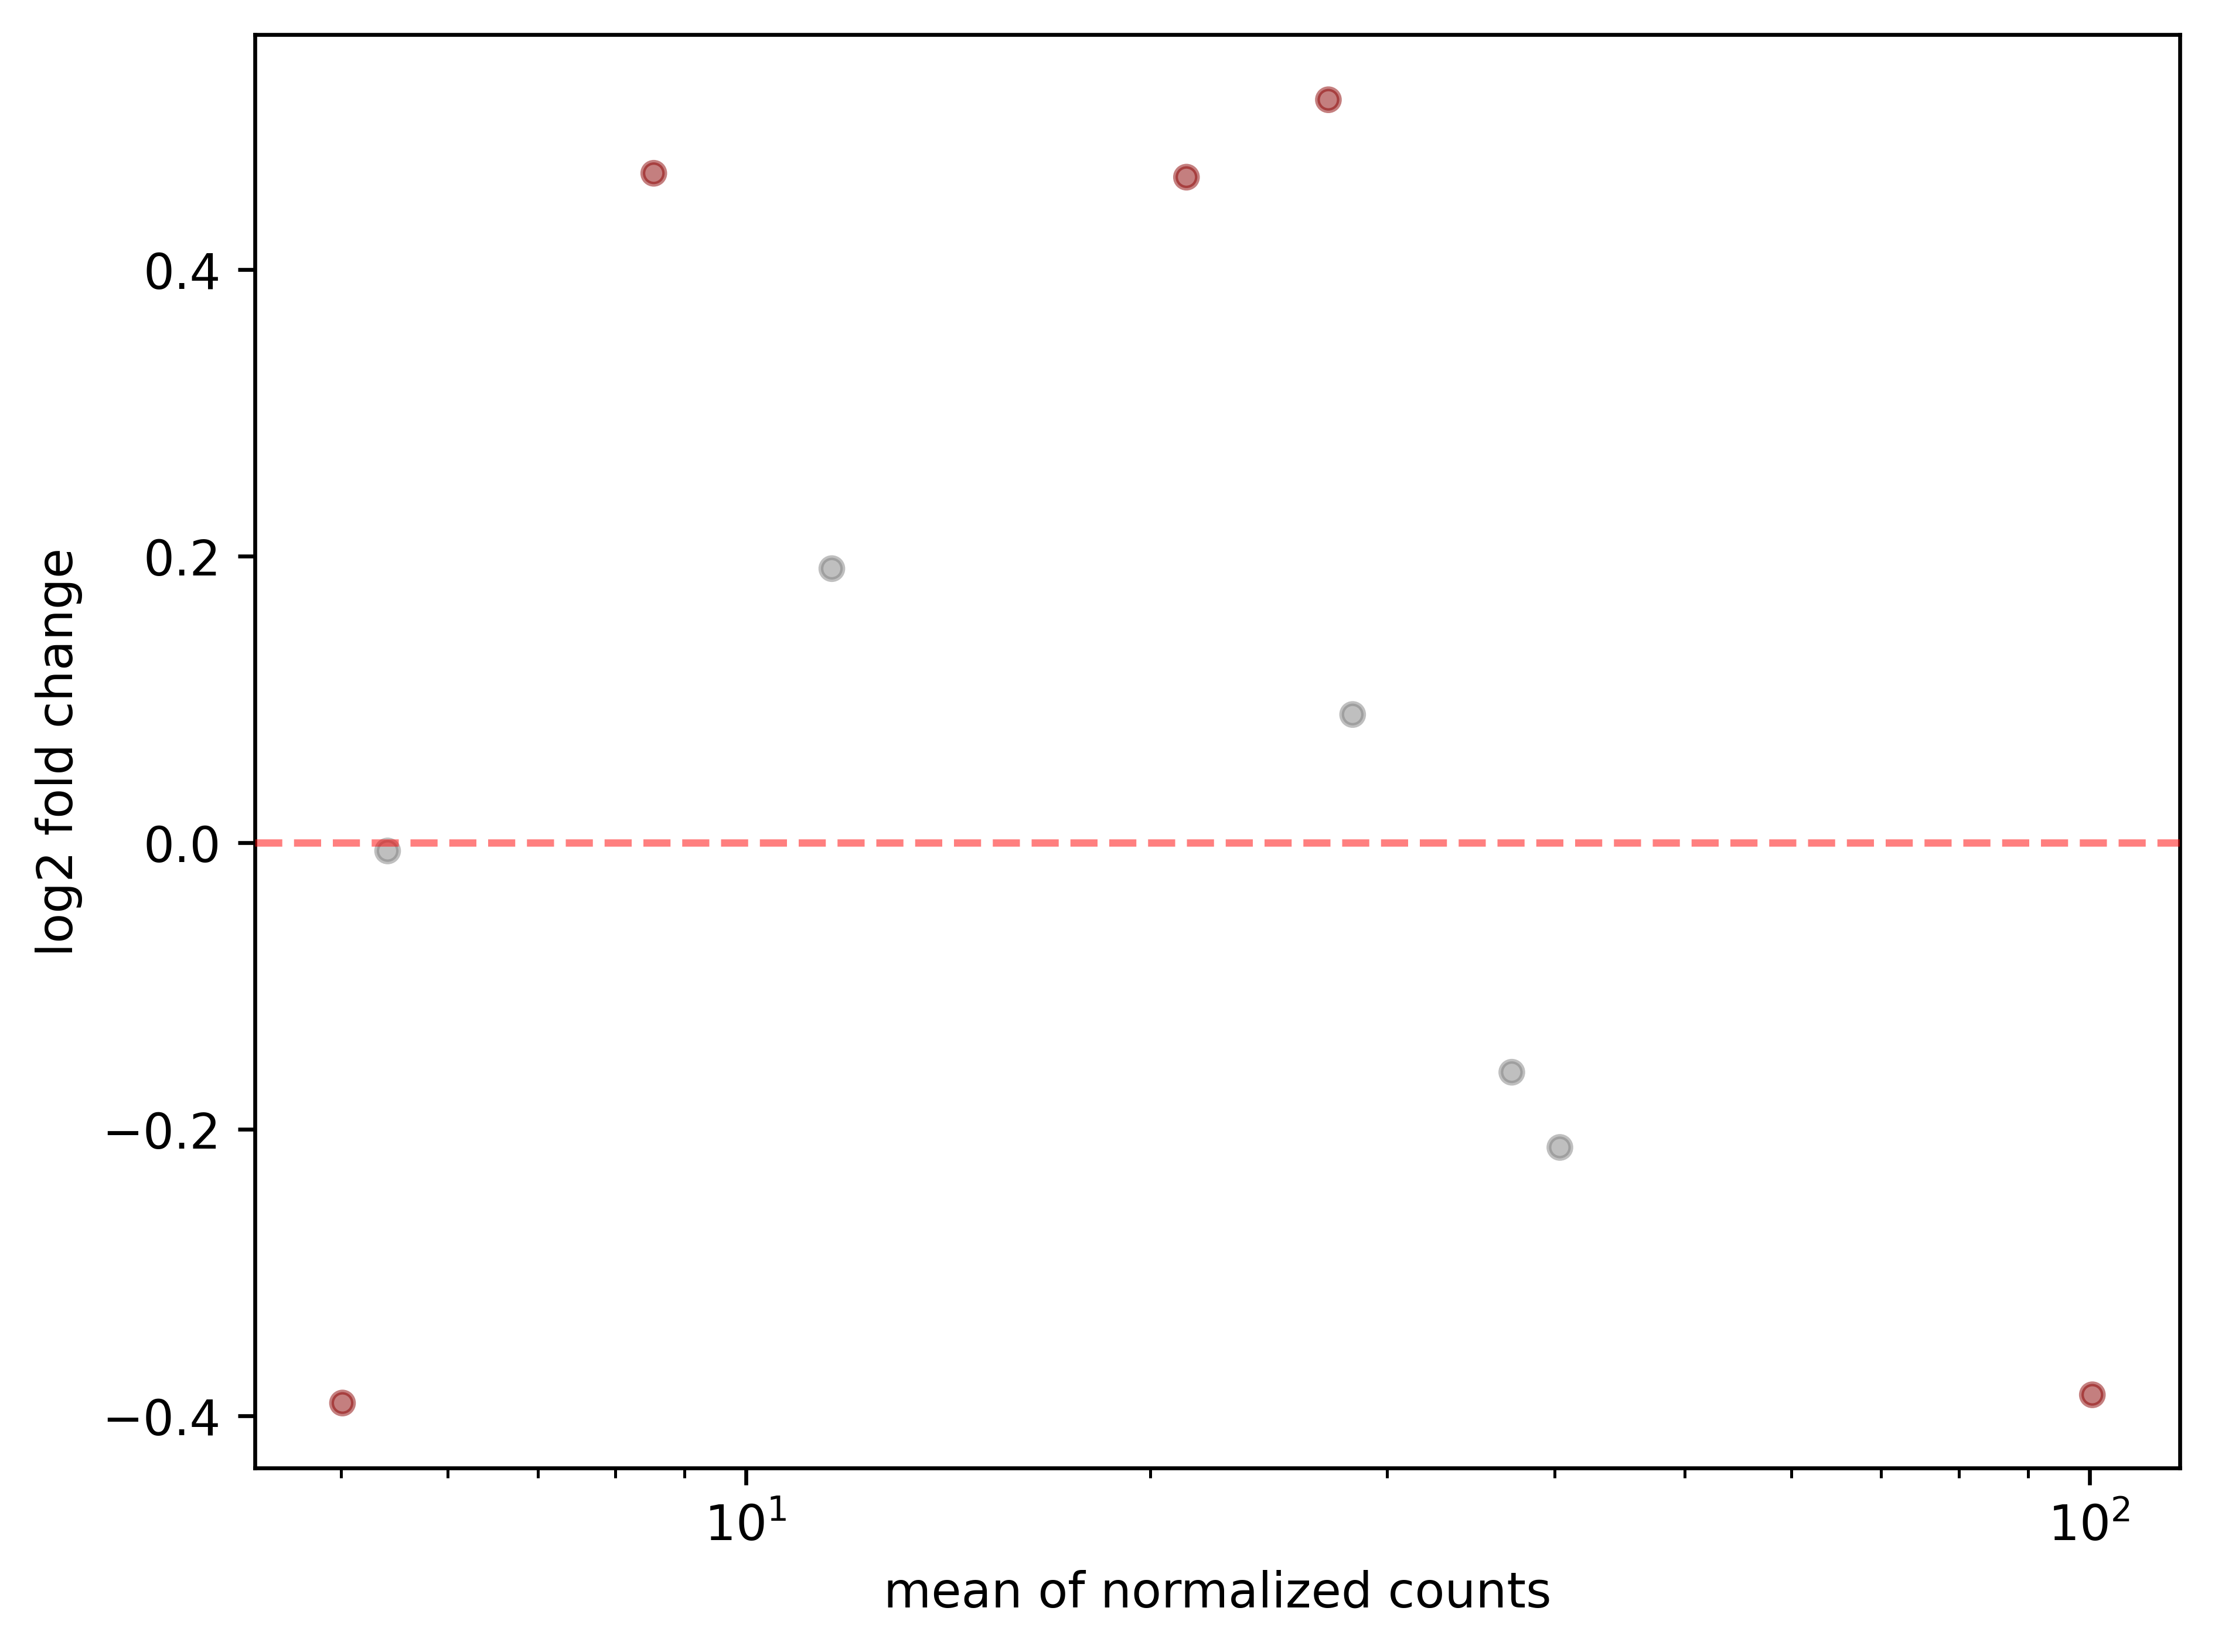

In [39]:
ds_B_vs_A.lfc_shrink(coeff="condition[T.B]")
ds_B_vs_A.plot_MA(s=20)  

